#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
# from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
from sympy import *

In [7]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [8]:
mp = 96 #  (submerged) [kg/m]

In [9]:
node_N=4

In [10]:
# diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
diag_Irho = 1e15*np.array([1, 1, 2]) # [m^4]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[1.e+15, 0.e+00, 0.e+00],
       [0.e+00, 1.e+15, 0.e+00],
       [0.e+00, 0.e+00, 2.e+15]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [20]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [21]:
rng = np.random.default_rng()

In [22]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [23]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [24]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[-0.36955255,  0.06434253, -0.92697948],
       [ 0.83050051,  0.4703187 , -0.29844467],
       [ 0.4167731 , -0.88014792, -0.22724397]])

In [25]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.000937


In [26]:
Ret

array([[[-0.36955255,  0.06434253, -0.92697948],
        [ 0.83050051,  0.4703187 , -0.29844467],
        [ 0.4167731 , -0.88014792, -0.22724397]],

       [[ 0.67608484, -0.02885626, -0.73625851],
        [-0.67342379, -0.42970345, -0.60154413],
        [-0.29901451,  0.90250887, -0.30994848]],

       [[-0.03492495, -0.01419855, -0.99928907],
        [-0.96462527,  0.26191329,  0.02999202],
        [ 0.26130125,  0.96498696, -0.02284358]],

       [[ 0.07769814,  0.99257368,  0.09359744],
        [-0.90303907,  0.03028383,  0.42848959],
        [ 0.42247301, -0.11781499,  0.89868581]]])

In [27]:
Ret.shape

(4, 3, 3)

In [28]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [29]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [30]:
dx**2

array([1.28316733, 2.34735764, 1.20226354, 0.19077701])

In [31]:
C1(dx,dy,dz,Ret)

array([[-0.3408568 ,  0.48646171,  0.27312381,  7.21865393],
       [ 1.18411911, -2.12205886, -1.36236072,  1.86686048],
       [ 0.41699264, -1.97121981, -0.39175168,  3.11439767]])

In [32]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [33]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000420


In [34]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [35]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([-1956.18872112,  6795.69973018,  2393.13489061])

In [36]:
fD(dx,dy,dz,DT,Ret)

array([[ -1956.18872112,   2791.82025292,   1567.46681633,
         41428.09989437],
       [  6795.69973018, -12178.56779235,  -7818.63440044,
         10713.97564946],
       [  2393.13489061, -11312.89739405,  -2248.27620022,
         17873.63391604]])

In [37]:
fD(dx,dy,dz,DT,Ret).T

array([[ -1956.18872112,   6795.69973018,   2393.13489061],
       [  2791.82025292, -12178.56779235, -11312.89739405],
       [  1567.46681633,  -7818.63440044,  -2248.27620022],
       [ 41428.09989437,  10713.97564946,  17873.63391604]])

In [38]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000485


In [39]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [40]:
I=np.identity(3)

In [41]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000321


In [42]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [43]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [44]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [45]:
DR=np.diag(diag_DR) 

In [46]:
dI= 0.69# Inner diameter of pipe, [m]

In [47]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [51]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [52]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [53]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [54]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [55]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [56]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [57]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [58]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [59]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [60]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000213


In [61]:
def phi(x, y, z, Ret):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T)

In [62]:
phi(x,y,z,Ret)

array([[-117.23188562,   73.9599869 ,  -40.46528549],
       [  75.99414384,   60.40648702,   47.4056593 ],
       [  -9.55545833,  -15.75257099,  190.04472002],
       [  17.91123137,  -79.18007323,   79.82894045]])

In [63]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [64]:
startTime1 = datetime.now()
phi(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.001028


In [65]:
def d_s(f,a,b,c,Ret):
#     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
#                  +np.diff(c,prepend=c[0])**2)
    ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
    ds[ds == 0] = 1
    fun = f(a,b,c,Ret)
    ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
    return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [66]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [67]:
d_s(phi,x,y,z,Ret)

array([[ 0.84907007, -0.40626014,  0.12095781,  0.15119727],
       [-0.05955653, -0.36166609, -0.27932205, -0.34915256],
       [ 0.3861208 ,  0.67736803, -0.48536827, -0.60671034]])

In [68]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000455


In [69]:
def ne(x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret).T
    return np.einsum('ijk,ik->ij', A,B-
                     np.einsum('ijk,kp->ijp',Ret, np.array([1,0,0]).reshape(3,1)).squeeze())

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
# sigma(x,y,z)

In [72]:
ne_(dx,dy,dz,DT,Ret)

array([[  1956.18872112,  -2791.82025292,  -1567.46681633,
        -41428.09989437],
       [ -6795.69973018,  12178.56779235,   7818.63440044,
        -10713.97564946],
       [ -2521.29943284,  11184.73285182,   2120.11165799,
        -18001.79845827]])

In [73]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [74]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000689


In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000207


In [76]:
Re_b(Ret).shape

(4, 3, 3)

In [77]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [78]:
Irho_e(Ret)

array([[[1.36569085e+14, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.21199677e+14, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.03279646e+14]],

       [[4.57090718e+14, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.84645053e+14, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.92136123e+14]],

       [[1.21975185e+12, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.85985713e+13, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.04365863e+12]],

       [[6.03700142e+12, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.17110144e+11, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.61527237e+15]]])

In [79]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000113


In [80]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [81]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [82]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001194


In [83]:
def ωe(φ,θ,ψ, dummy):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T)

In [84]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None)
print(datetime.now() - startTime1)

0:00:00.000381


In [85]:
ωe(φ,θ,ψ,None)

array([[ 0.24830759, -1.81816488, -0.89201381],
       [ 1.39930145, -0.86544267,  1.49358588],
       [ 0.19911985, -1.30132475,  0.92804415],
       [-0.56906899, -0.54868169, -1.29980421]])

In [86]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [87]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [88]:
def d_me(φ,θ,ψ,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(ωe,φ,θ,ψ,None)
    return np.einsum('ijk,ik->ij', A,B.T) 

In [89]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret)
print(datetime.now() - startTime1)

0:00:00.003048


In [90]:
d_me_

array([[ 4.94871286e+09,  6.63464403e+09,  3.87836934e+09],
       [-3.81922107e+10, -5.60314841e+09, -3.78241447e+09],
       [-3.06413584e+07,  1.68838960e+09, -3.80174192e+07],
       [-1.89569219e+08,  2.82155881e+07, -7.35495368e+10]])

In [91]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [92]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [93]:
ne_(dx,dy,dz,DT,Ret)

array([[  1956.18872112,  -2791.82025292,  -1567.46681633,
        -41428.09989437],
       [ -6795.69973018,  12178.56779235,   7818.63440044,
        -10713.97564946],
       [ -2521.29943284,  11184.73285182,   2120.11165799,
        -18001.79845827]])

In [94]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [95]:
Re_b(Ret).shape

(4, 3, 3)

In [96]:
ne_(dx,dy,dz,DT, Ret).T

array([[  1956.18872112,  -6795.69973018,  -2521.29943284],
       [ -2791.82025292,  12178.56779235,  11184.73285182],
       [ -1567.46681633,   7818.63440044,   2120.11165799],
       [-41428.09989437, -10713.97564946, -18001.79845827]])

In [97]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ 62.85720596,  14.63424549, 179.40054227,   5.97529537]),
 array([  95.79408039, -106.98181517,    4.73491121,   39.48974404]),
 array([ 1.13276976, -1.53210888, -1.09647779,  0.43678027]),
 numpy.ndarray,
 array([-0.28591668,  1.15112364, -0.34100141,  1.50391187]))

In [98]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T)

array([[  3133.21454668,  -7614.76025307,   4848.15848693],
       [-13265.61033475,   2097.36302724,  19544.10212049],
       [ -3742.34077354,  11442.04318533,   9206.97990837],
       [-56966.31886496,  18659.17354776, -50419.74626911]])

In [99]:
ne_(dx,dy,dz,DT,Ret).T

array([[  1956.18872112,  -6795.69973018,  -2521.29943284],
       [ -2791.82025292,  12178.56779235,  11184.73285182],
       [ -1567.46681633,   7818.63440044,   2120.11165799],
       [-41428.09989437, -10713.97564946, -18001.79845827]])

### Vessel

In [100]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [101]:
V=VesselSemisub()

In [102]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [103]:
tau_force = V.tau(η,dη, ddη)

In [104]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [105]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [106]:
V=VesselOtter()

In [107]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [108]:
tau_force = V.tau(η,dη, ddη)

In [109]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [110]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [111]:
V=VesselSemisub()

In [112]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e4, 1.5e4
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [113]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [114]:
Hs = 2.5 # significant wave height in m

In [115]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [116]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [117]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [118]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [119]:
tau(η, dη, wave_coef, kp, kd,3)

array([5828.76914536, 7132.08869406,    0.        ,    0.        ,
          0.        ,    0.        ])

### Static solution

In [120]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [121]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [122]:
Fx_0=82945396

In [123]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [124]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [125]:
delta_x=horizontal_length/(node_N-1)

In [126]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [127]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

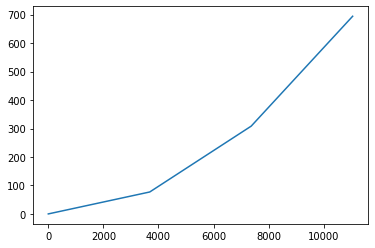

In [128]:
plt.plot(x0, z0)
plt.show()

In [129]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [130]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [131]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
   
    Z1 = d_s(ne, x, y, z, Ret).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws*Re_b(Ret),Z).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret)
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [132]:
q0

array([ 0.00000000e+00,  3.68422828e+03,  7.36845656e+03,  1.10526848e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.70680464e+01,  3.08407059e+02,  6.94421895e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.91869842e-01,  4.99204015e-02, -1.65190166e-01, -1.67969390e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.26158775e-02, -2.25711081e-01,  2.96922773e-01, -4.88928601e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [133]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [134]:
root

array([ 2.90194093e+03,  3.62627132e+03,  6.89799489e+03,  1.80497678e+04,
        1.41286735e-13, -1.94486551e-14, -1.09343790e-13,  1.36634311e-15,
       -1.37305666e+03,  2.46328573e+03, -1.94774164e+03, -7.90537418e+01,
        8.39055971e-14,  8.30460303e-14,  1.13209466e-14,  2.25922234e-14,
       -3.12632143e+03,  1.83803948e+03, -1.17953245e+03,  3.16742090e+03,
        7.79028455e-15,  3.03829839e-15, -4.11426828e-14, -1.09045422e-15,
        3.93858937e-01, -1.85314113e-01, -8.45580290e-02, -5.68292546e-01,
       -8.96792034e-22, -1.49736547e-22,  2.41348405e-22, -9.40247190e-23,
        1.42024256e+00, -1.62369148e-01, -6.23745493e-02, -3.78537716e-01,
        1.98484345e-22,  4.28875616e-22,  4.48337146e-23, -8.54652495e-24,
       -9.77921378e-01,  1.32588699e-01,  1.72613096e-01,  9.57651272e-02,
        1.17191639e-22,  3.37927628e-23,  2.71635484e-23,  1.26158553e-24])

In [135]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [136]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [137]:
x0_

array([ 2901.94093367,  3626.27132424,  6897.99488867, 18049.76778016])

In [138]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [139]:
z0_

array([-3126.32142765,  1838.03948201, -1179.53244715,  3167.42089742])

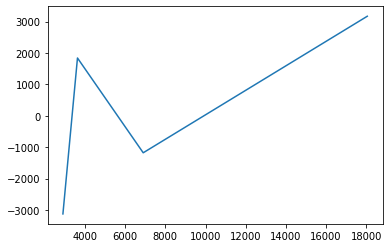

In [140]:
plt.plot(x0_, z0_)
plt.show()

In [141]:
# for j in range(1,12):
#     if j==1:  
#         q0[(j-1)*node_N:j*node_N]=x0_
#     elif j==5:    
#         q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [142]:
# q0[10*node_N]=q0[8*node_N]=0

In [143]:
q0

array([ 0.00000000e+00,  3.68422828e+03,  7.36845656e+03,  1.10526848e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.70680464e+01,  3.08407059e+02,  6.94421895e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.91869842e-01,  4.99204015e-02, -1.65190166e-01, -1.67969390e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.26158775e-02, -2.25711081e-01,  2.96922773e-01, -4.88928601e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

### Dynamics

In [144]:
# # def grayscott1d(Q,p,t):
# def grayscott1d(t, Q):
#     print(t)
     
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

#     x[0]=0
#     y[0]=0
#     z[0]=0

#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
#     Ret = Re_t(φ,θ,ψ)

#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
#     dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
#     left=V.eq_left(η,dη)

#     # PD controller after 30 sec
# #     if t<30:
# #         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_force, Fx_0/η[0], 0, t), rcond=None)[0]
# #     else:

#     hack =1
#     ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, -left.astype(np.float32) 
#                         + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#                         , rcond=None)[0]
# #     print('ddη', ddη)
 
#     tau_force = V.tau(η,dη,ddη).astype(np.float32)

#     C=ne(x,y,z,Ret)

  
#     a,b,c=C[:,0],C[:,1],C[:,2]
# #     Z0=tau_force[:3]
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
   
#     Z1 = d_s(a,b,c,x,y,z).T

#     Z2=ne_(dx,dy,dz,DT,Ret).T
    
#     Z= ( np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) + Z0)

     
# ############################################################    
# #     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
# ############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
 
    
#     me_=me(φ,θ,ψ,x,y,z,Ret)

#     C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
#                  np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T

#     C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))

#     K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

#     C5= -np.dot(DR,K1).astype(np.float32).T

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
#     B_ =(-C1-C2+C3+C4+C5)
#     B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       
#        +C0.squeeze()
       
#       )

#     A2 = Irho_e(Ret).astype(np.float32)
#     A3=Π(φ,θ,ψ).astype(np.float32)

# #     A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

# ############################################
# #     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
# #############################################

#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)

#     A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
# #     A1111=np.concatenate([dx, ddx, 
# #                           np.zeros(node_N), np.zeros(node_N),
# #                           dz, ddz,
# #                           np.zeros(node_N),  np.zeros(node_N),
# #                           np.zeros(node_N), np.zeros(node_N),
# #                           np.zeros(node_N),  np.zeros(node_N),
# #                           ], axis=0)

        

# #     print(A1111)
#     return A1111

In [145]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     x[-1]=x0_[-1]+10*np.sin(t)
    x[-1]=x0[-1]+10*np.sin(t)
    y[-1]+=5*np.cos(t)
#     z[-1]=z0_[-1]+2.5*np.sin(t)
    z[-1]=z0[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
#     left=V.eq_left(η,dη)

    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:

#     hack =1
#     ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, left.astype(np.float32) 
#                         - tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#                         , rcond=None)[0]
#     print('ddη', ddη)
 
#     tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force = tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

#     Z0=np.dot(Re_b(Ret),tau_force[:3])
   
    Z1 =d_s(ne, x, y, z, Ret).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
#         + Z0
       )

     
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=np.linalg.lstsq(Ws*RRRR[i], Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z) 
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret)
#     print(d_s(phi,x,y,z,Ret).T)
    C4= np.cross(d_s(phi,x,y,z,Ret).T, ne(x,y,z,Ret))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= -np.dot(DR,K1).astype(np.float32).T
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [146]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [147]:
# tspan = (0., 60)
tspan = (0., 10)

In [148]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
7.27457949690986e-08
1.454915899381972e-06
2.182373849072958e-06
5.819663597527888e-06
6.4662928861420975e-06
7.27457949690986e-06
7.27457949690986e-06
1.4749520001029441e-05
1.848699025308923e-05
3.717434151338819e-05
4.049653729299689e-05
4.464928201750777e-05
4.464928201750777e-05
7.666718239971247e-05
9.267613259081481e-05
0.00017272088354632658
0.0001869510614939731
0.00020473878392853126
0.00020473878392853126
0.0003309361134596234
0.00039403477822516956
0.0007095281020528999
0.0007656158040667187
0.0008357254315839921
0.0008357254315839921
0.001321429697333333
0.0015642818302080035
0.002778542494581356
0.002994411057136618
0.003264246760330697
0.003264246760330697
0.005113842676387935
0.006038640634416554
0.010662630424559647
0.01148467305391842
0.012512226340616883
0.012512226340616883
0.016723101302116385
0.018828538782866132
0.029355726186614885
0.03122722616950355
0.03356660114811438
0.03356660114811438
0.014878958158301162
0.0160623240671433
0.021979153611353996
0.02303

1.920870967877424
1.9232779926621562
1.9262867736430715
1.9262867736430715
1.9328062795678722
1.9360660325302725
1.952364797342274
1.9552623555310742
1.9588843032670746
1.9588843032670746
1.9661883869514207
1.9698404287935938
1.9881006380044588
1.9913468974197237
1.995404721688805
1.995404721688805
1.965314260048675
1.9685292384394752
1.9846041303934765
1.9874618889630766
1.991034087175077
1.991034087175077
1.9974640439566773
2.0006790223474775
2.0167539143014785
2.0196116728710787
2.023183871083079
2.023183871083079
2.0292787830537926
2.032326239039149
2.0475635189659327
2.0502723687306945
2.0536584309366464
2.0536584309366464
2.059211626132866
2.0619882237309755
2.0758712117215237
2.078339298475399
2.081424406917743
2.081424406917743
2.086899622341445
2.0896372300532957
2.1033252686125503
2.105758697689751
2.108800484036252
2.108800484036252
2.114882319125195
2.1179232366696663
2.133127824392023
2.135830862209331
2.139209659480966
2.139209659480966
2.1460535947440316
2.14947556237556

3.8456465095576444
3.8163953130675687
3.8195000638258976
3.835023817617542
3.83778359606939
3.8412333191342
3.8412333191342
3.8474428206508575
3.8505475714091864
3.866071325200831
3.8688311036526786
3.8722808267174886
3.8722808267174886
3.87849216203627
3.8815978296956604
3.8971261679926132
3.899886761467627
3.9033375033113944
3.9033375033113944
3.9092023123389614
3.912134716852745
3.9267967394216625
3.929403321211692
3.9326615484492295
3.9326615484492295
3.9381998386880124
3.940968983807404
3.954814709404361
3.9572761717327087
3.9603529996431437
3.9603529996431437
3.966012402142449
3.9688421033921015
3.982990609640365
3.9855058996400565
3.9886500121396704
3.9886500121396704
3.994868412641059
3.9979776128917535
4.013523614145225
4.016287347701398
4.019742014646614
4.019742014646614
4.02636371386122
4.029674563468523
4.046228811505039
4.049171788933753
4.0528505107196455
4.0528505107196455
4.059034607724357
4.062126656226712
4.07758689873849
4.08033538629614
4.083770995743201
4.08377099

5.727259751255487
5.727259751255487
5.732409978925718
5.734985092760833
5.747860661936408
5.750149652012066
5.753010889606639
5.753010889606639
5.7584862613434185
5.761223947211809
5.7749123765537576
5.777345875103437
5.780387748290537
5.780387748290537
5.786369536696035
5.7893604308987845
5.804314901912529
5.806973474537195
5.810296690318027
5.810296690318027
5.816318223732374
5.819328990439548
5.8343828239754165
5.83705906104846
5.8404043573897635
5.8404043573897635
5.845956416962108
5.848732446748279
5.862612595679138
5.865080177711292
5.868164655251483
5.868164655251483
5.87335303604764
5.87594722644572
5.888918178436115
5.891224125456629
5.894106559232273
5.894106559232273
5.899478407776257
5.90216433204825
5.915593953408212
5.917981441649983
5.920965801952197
5.920965801952197
5.926823336808424
5.929752104236537
5.944395941377105
5.946999290202095
5.950253476233333
5.950253476233333
5.95627862657994
5.959291201753244
5.974354077619763
5.977031922218255
5.98037922796637
5.98037922

7.972817183360453
7.975863729818111
7.975863729818111
7.982094891013083
7.985210471610569
8.000788374597999
8.003557779573542
8.00701953579297
8.00701953579297
8.01373397284129
8.017091191365449
8.033877283986246
8.036861478229945
8.040591721034566
8.040591721034566
8.046766016618413
8.049853164410337
8.065288903369954
8.068033034740552
8.0714631989538
8.0714631989538
8.045810473067558
8.048419849084055
8.061466729166536
8.063786174514533
8.066685481199528
8.066685481199528
8.07190423323252
8.074513609249017
8.087560489331498
8.089879934679495
8.09277924136449
8.09277924136449
8.099215025538914
8.102432917626126
8.118522378062188
8.121382726584155
8.124958162236613
8.124958162236613
8.132334111514334
8.136022086153194
8.154461959347495
8.157740159026483
8.161837908625216
8.161837908625216
8.13144979949643
8.134695618126337
8.150924711275877
8.153809883391352
8.157416348535694
8.157416348535694
8.163907985795511
8.167153804425418
8.183382897574958
8.186268069690433
8.189874534834775
8.1

9.985957604306714
9.989164566904837
9.989164566904837
9.991331653523869
9.992415196833386
9.997832913380968
9.998796062989426
10.0
10.0
0:00:11.060952


In [149]:
fin=us

In [150]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [151]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 2378
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 7.27457950e-06, 4.46492820e-05, 2.04738784e-04,
       8.35725432e-04, 3.26424676e-03, 1.25122263e-02, 2.43458854e-02,
       3.61795445e-02, 5.28160384e-02, 7.23655205e-02, 9.88053783e-02,
       1.31819841e-01, 1.58915436e-01, 1.86011031e-01, 2.15694773e-01,
       2.46151929e-01, 2.74675051e-01, 3.01172917e-01, 3.28068841e-01,
       3.57205732e-01, 3.87577096e-01, 4.16656110e-01, 4.43697228e-01,
       4.70541776e-01, 4.99224796e-01, 5.29453162e-01, 5.58993910e-01,
       5.86588764e-01, 6.13488943e-01, 6.41793623e-01, 6.71845056e-01,
       7.01784182e-01, 7.29947945e-01, 7.56985272e-01, 7.84961915e-01,
       8.14802833e-01, 8.45099536e-01, 8.73868585e-01, 9.01118885e-01,
       9.28789950e-01, 9.58363300e-01, 9.88984026e-01, 1.01843082e+00,
       1.04599138e+00, 1.07335518e+00, 

In [152]:
t=fin.t

In [153]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


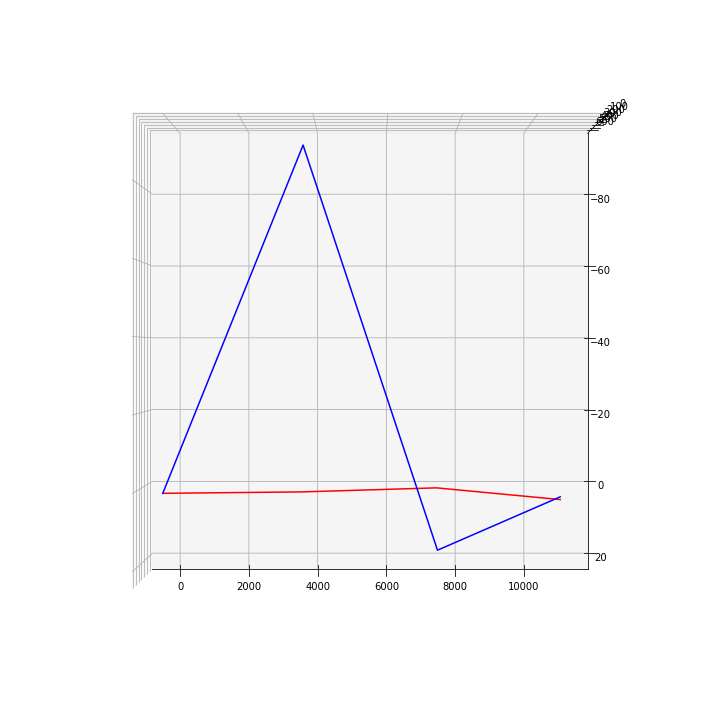

In [173]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [155]:
X,Y,Z

(array([    0.        ,  3727.32022439,  7395.12792573, 11047.24463335]),
 array([  0.        , -89.26635369,  16.57091447,   4.22980195]),
 array([  0.        ,  56.18318061, 312.74959529, 693.06184233]))

In [156]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 5.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [157]:
us=fin.T

In [158]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

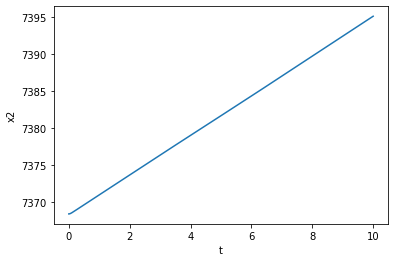

In [159]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

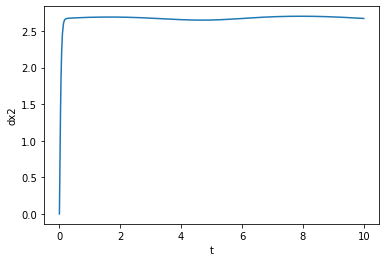

In [160]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

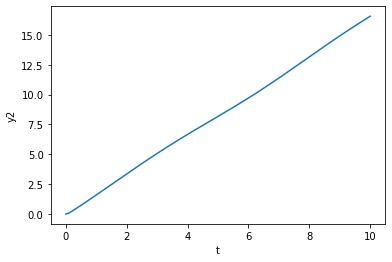

In [161]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

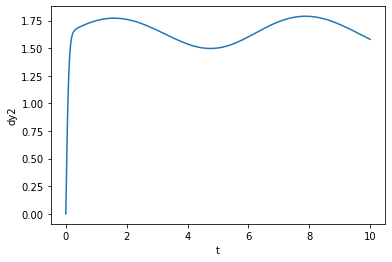

In [162]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

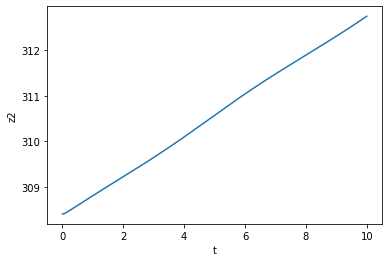

In [163]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

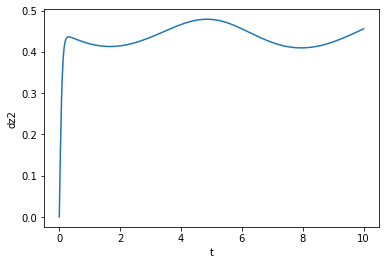

In [164]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

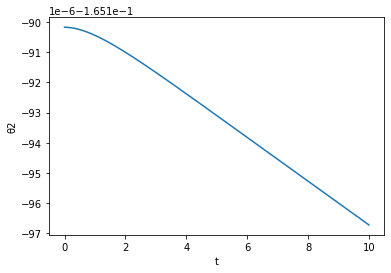

In [165]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

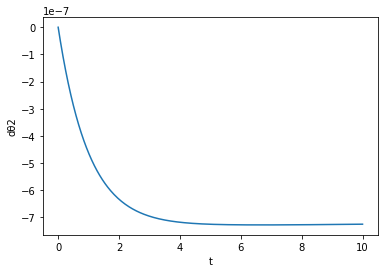

In [166]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

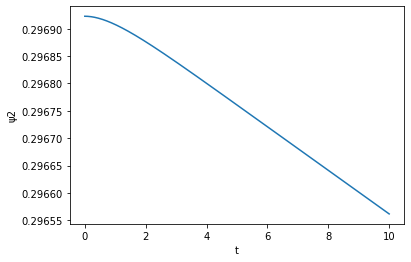

In [167]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

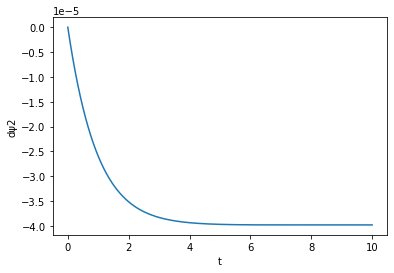

In [168]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()